# Image Classification using OpenVino

This notebook demonstrates how to do image classification with OpenVino. In this notebook, we will use Mobile-Net v3 pre-trained model which is trained using ImageNet dataset.

## The Libraries

We need 4 library to run this notebook. Those libraries include : 
- OpenCV (cv2) to load the image file, capture image from camera, and do other image processing techniques.
- Numpy to do an array opperation. 
- matplotlib to visualize the image on the notebook
- OpenVino to load the model and do the object detection using the model  

## Import the libraries

In [1]:
from openvino.inference_engine import IECore
import cv2
import numpy as np
import matplotlib.pyplot as plt

D:\Python38\lib\site-packages\ipykernel\pylab\config.py:70: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


## Load the model

In this step, we will load the model using the Inference Engine from OpenVino library. First, we create the inference engine core object (IECore) and then load the model. There are 2 files that which need to be loaded, the model architecture file (the .xml file) and its weight (the .bin file).

In [2]:
ie = IECore()

net = ie.read_network(
    model = 'v3-small_224_1.0_float.xml',
    weights = 'v3-small_224_1.0_float.bin'
)

model = ie.load_network(net, "CPU")

D:\Python38\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Get Some Informations about the model
Each model has its own specification, so at this step we need to know some of the Informations such as

- the input label
- the output label
- the input size; and
- the input data type

In [4]:
print("Model input label     : ",model.input_info)
print("Model output label    : ",model.outputs)
print("Model input shape     : ", model.input_info['input'].tensor_desc.dims)
print("Model input data type : ",model.input_info['input'].precision)

Model input label     :  {'input': <openvino.inference_engine.ie_api.InputInfoCPtr object at 0x0000026A4B415E30>}
Model output label    :  {'MobilenetV3/Predictions/Softmax': <openvino.inference_engine.ie_api.CDataPtr object at 0x0000026A4B415D30>}
Model input shape     :  [1, 3, 224, 224]
Model input data type :  FP32


In [5]:
input_key = list(model.input_info.keys())[0]
output_key = list(model.outputs.keys())[0]
print("Input key    : ",input_key)
print("Output key   : ",output_key)

Input key    :  input
Output key   :  MobilenetV3/Predictions/Softmax


## Load the image

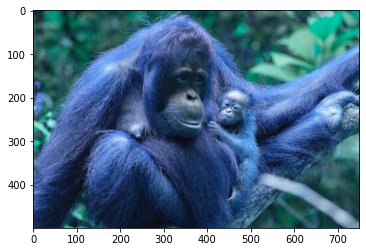

In [28]:
img = cv2.imread('orangutan.jpg')
plt.imshow(img)

In [29]:
img.shape

(500, 750, 3)

## Process the Image

Before we do the inference, we need to make sure that the image shape is equal to the model input shape. The model input shape format is (B,C,H,W) which respectively represent :
- B --> Batch Size (number of processed data)
- C --> Number of image channel (mostly 3 for RGB Image / Colored Image)
- H --> Image Height
- W --> Image Width


In [30]:
# get the model input shape

B,C,H,W = model.input_info[input_key].tensor_desc.dims

resized = cv2.resize(img,(W,H))
resized.shape

(224, 224, 3)

The image shape still in format (H,W,C), so we need to reorder the format into (C,H,W) by applying np.transpose() function

In [31]:
transposed = np.transpose(resized,(2,0,1))
transposed.shape

(3, 224, 224)

We have reorder the image shape into (C,H,W) format. The model needs the input in a form of batched-array so we need to encapsulate the image in a form of new np.array. We also need to change the datatype into float32 because our model use FP32 as the input datatype.

In [32]:
input_image = np.array([transposed])
input_image.shape

(1, 3, 224, 224)

Here, You will see that both shapes are equal

In [33]:
print("Image shape       : ", input_image.shape)
print("Model input shape : ", model.input_info[input_key].tensor_desc.dims)

Image shape       :  (1, 3, 224, 224)
Model input shape :  [1, 3, 224, 224]


## Do the inference

To do the inference, we simply use the model.infer() function and set the parameter in a form of dictionary. 

In [34]:
result = model.infer({input_key:input_image})
result

{'MobilenetV3/Predictions/Softmax': array([[1.1784075e-04, 4.0137784e-05, 1.5684207e-04, ..., 6.1903535e-05,
         2.0645275e-04, 1.5835139e-04]], dtype=float32)}

The output of image classification model is an array of confidence value for each classes. ImageNet dataset itself has 1000 classes. To get the predicted image classification we need to find the index of highest confidence value in the array using np.argmax() function.

In [35]:
result_index = np.argmax(result[output_key])
result_index


368

To get the label we need to load the pre-defined ImageNet label on "imagenet_class_index.json", then we need to access the key based on the index of the highest confidence value in model output. We need to substract the index by 1 because the first element of the model outbut is the background.

In [36]:
import json

img_classes = json.load(open('imagenet_class_index.json','r'))

img_classes[str(result_index-1)]

['n02481823', 'chimpanzee']

Here, you will see the predicted image and its confidence value.

Predicted label  :  chimpanzee
Confidence       :  0.3695946


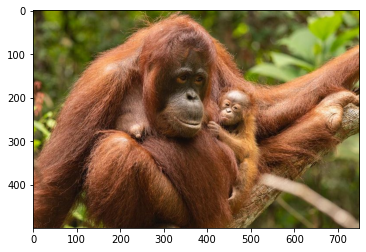

In [37]:
print("Predicted label  : ", img_classes[str(result_index-1)][1])
print("Confidence       : ", result[output_key][0][result_index])
output_image = cv2.cvtColor(img.copy(),cv2.COLOR_BGR2RGB)
plt.imshow(output_image)

You can try with other image and see if the prediction is correct or not.

## Reference

This notebook is sourced from https://github.com/openvinotoolkit/openvino_notebooks with some modifications.